### I. INTRODUCTION
   *Name: Nurfiah Idris*  
   *Batch: 005*

**Data Set Information:**  

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The dataset constains of 41188 instances and 21 columns. More information of the dataset can be accessed [here]("https://archive.ics.uci.edu/ml/datasets/Bank+Marketing").

### II. LIBARARY

In [ ]:
# Standard modules
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing modules
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
# Machine Learning model

# Deployment purposes
import joblib

### III. DATA LOADING

In [7]:
# Load data.
df_raw = pd.read_csv("/Users/nurfiahidris/Desktop/DS-Hacktiv8/Hacktiv8-Assignment/P1/DSM2_BankSubscriptionCampaign/bank-additional-full.csv",delimiter=";")
df = df_raw.copy()
df.shape

(41188, 21)

### IV. DATA CLEANING

In [8]:
# Get first five instances of data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Handle Missing Values**

Here I will create table to display number of missing value in percentage, data type, and total unique of each column.

In [9]:
# Find dataset misisng values.
dataset_info = df.isnull().sum()/df.shape[0]*100
dataset_info = dataset_info.reset_index()
dataset_info = dataset_info.rename(columns={'index': 'column_name',0:'missing %'})
# Find dataset types.
types = df.dtypes.reset_index()
types = types.rename(columns = {0:'type'})
dataset_info['type'] = types['type']
# Find dataset total uniques.
uniques= df.nunique().reset_index()
uniques = uniques.rename(columns = {0:'unique'})
dataset_info['unique'] = uniques['unique']
dataset_info

,column_name,missing %,type,unique
0,age,0.0,int64,78
1,job,0.0,object,12
2,marital,0.0,object,4
3,education,0.0,object,8
4,default,0.0,object,3
5,housing,0.0,object,3
6,loan,0.0,object,3
7,contact,0.0,object,2
8,month,0.0,object,10
9,day_of_week,0.0,object,5


Fortunately, no missing points on the dataset, hence no further action needed.

### V. DATA EXPLORATION

### Categorical Column

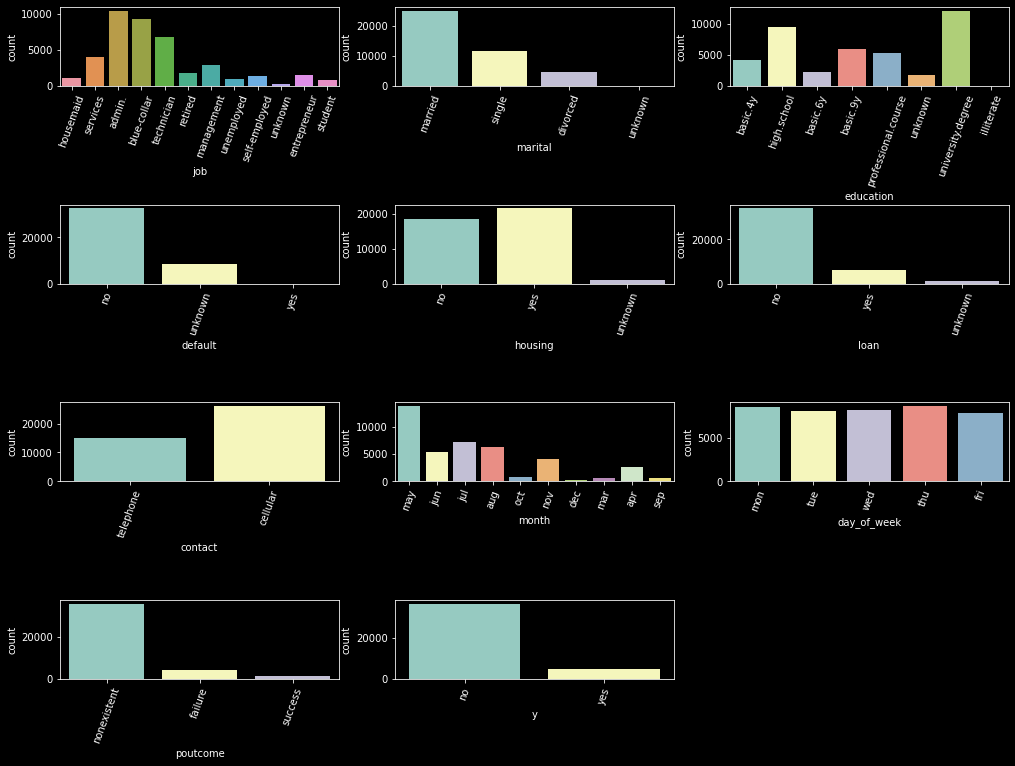

In [10]:
# Display categorical column on countplot
plt.figure(figsize=(17,16))
plt.subplots_adjust(hspace=1.5)
for i, col in enumerate(df.select_dtypes('object')):
    ax = plt.subplot(5,3,i+1)
    plt.xticks(rotation = 70)
    sns.countplot(data=df, x=col)

**Handle Unknown Values**  

Seems like some column with have unknow value. I will handle it with different ways of each column, more description as follows:
1. Reduce dimention by creating new column named has_loan based on existing data which is loan and housing column. After that, I will drop loan and housing column and using new created column instead as representation of deleted column and drop all rows with unknown value on new column which is has_loan column.
2. Unknown value on default column will be replaced by the value that appears most often on that column (modus of default column). 
3. Drop all Unknown value on marital column.

In [11]:
# Create new column named has_loan.
condition = [(df.loan == 'yes') | (df.housing == 'yes'),(df.loan == 'no') & (df.housing == 'no') ]
choices = ['yes','no',]
df['has_loan'] = np.select(condition,choices,default='unknown')

# Drop housing and loan column.
df.drop(columns=['loan','housing'], axis=1, inplace=True)

# Drop all unknown data from has_loan column
df = df[df['has_loan'] != 'unknown']

# Drop all unknown value on marital column
df = df[df['marital'] != 'unknown']


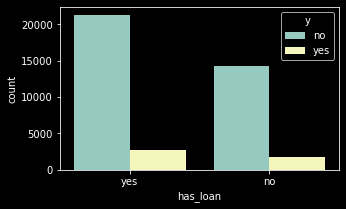

In [12]:
# Ploting has loan column and the total of subscription
plt.figure(figsize=[5,3])
sns.countplot(data=df, x='has_loan',hue='y', order=df['has_loan'].value_counts().index)
plt.show()

**Handle Nonexistent Value on Poutcome Column**  

Poutcome is the outome of the previous campaign and I deeply consider it as the factor which might influence in predicting the next campaign success. However, this column mostly consists of nonexistent value which means most of them did not join in the previous campaign. In order to keep this record exist, I will create another column named prev_campaign and then drop poutcome column.

In [13]:
# Create new column named prev_campaign.
df['old_campaign'] = np.where(df['poutcome'] == 'nonexistent', 'no','yes')
# Drop poutome column.
df.drop('poutcome', axis=1,inplace=True)

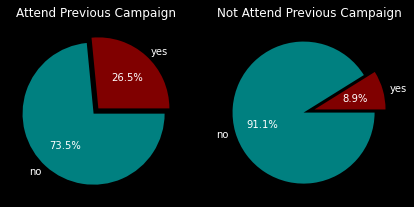

In [14]:
# Compare total subscriber from old_campaign.
fig, axs = plt.subplots(ncols=2, figsize=(7,4))
yes = df[(df['old_campaign'] == 'yes') & (df['y'] == 'yes')]
yes_total = df[df['old_campaign'] == 'yes']
yes.shape[0]/yes_total.shape[0]*100

no = df[(df['old_campaign'] == 'yes') & (df['y'] == 'no')]
no_total = df[df['old_campaign'] == 'yes']
no.shape[0]/no_total.shape[0]*100

axs[0].pie(x=[yes.shape[0]/yes_total.shape[0]*100,no.shape[0]/no_total.shape[0]*100], autopct="%.1f%%", explode=[0.05]*2,labels=['yes','no'], colors=['maroon','teal'])
axs[0].set_title('Attend Previous Campaign')

yes = df[(df['old_campaign'] == 'no') & (df['y'] == 'yes')]
yes_total = df[df['old_campaign'] == 'no']
yes.shape[0]/yes_total.shape[0]*100

no = df[(df['old_campaign'] == 'no') & (df['y'] == 'no')]
no_total = df[df['old_campaign'] == 'no']
no.shape[0]/no_total.shape[0]*100
axs[1].pie(x=[yes.shape[0]/yes_total.shape[0]*100,no.shape[0]/no_total.shape[0]*100], autopct="%.1f%%", explode=[0.08]*2,labels=['yes','no'], colors=['maroon','teal'])
axs[1].set_title('Not Attend Previous Campaign')
plt.show()


*Insight:*  

The chart shows that the client who successfully subscribed a term deposit of the bank are coming from the client that join the previous campaign. 

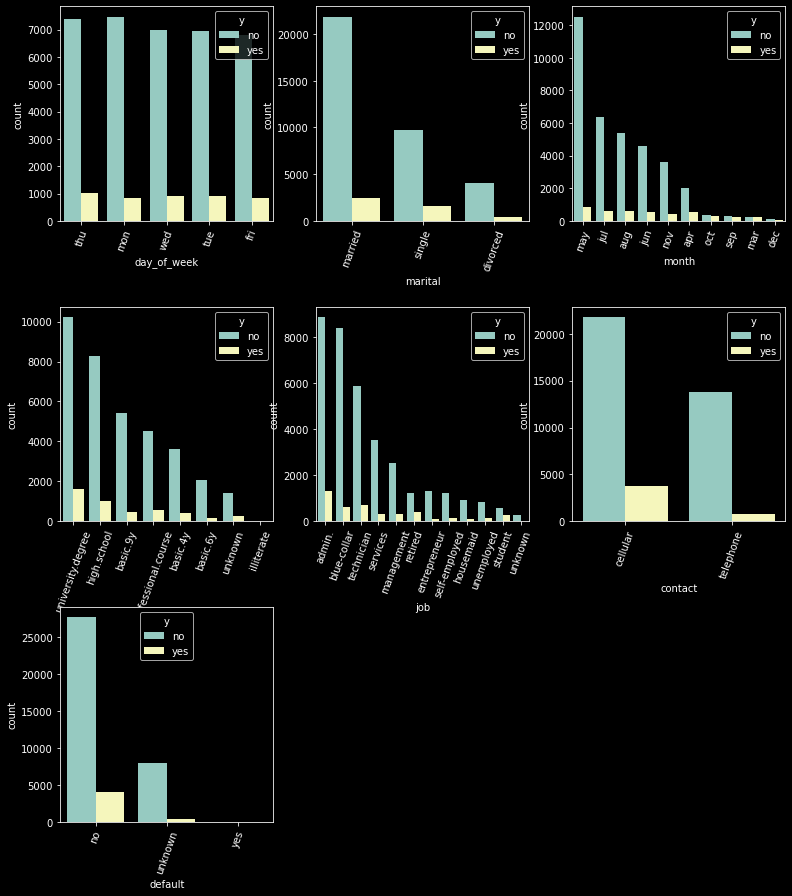

In [15]:
# Ploting categorical columns.
arr = ['day_of_week','marital', 'month','education','job', 'contact','default']
plt.figure(figsize=(13,15))
plt.subplots_adjust(hspace=0.4)
for i, col in enumerate(arr):
    ax = plt.subplot(3,3,i+1)
    plt.xticks(rotation = 70)
    sns.countplot(data=df, x=col,hue='y', order=df[col].value_counts().index)

We will just drop the column day_of_week and marital column since based on it's distibution above shows that the don't influnce clients behaviours towards bank term deposit subscription. 

In [16]:
# Drop day_of_week and marital column.
df.drop('day_of_week', axis=1, inplace=True)
df.drop('marital', axis=1, inplace=True)

### Numerical Column

In [17]:
# Dataset description.
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,40119.000000,40119.000000,40119.000000,40119.000000,40119.000000,40119.000000,40119.000000,40119.000000,40119.000000,40119.000000
mean,40.025649,258.384855,2.566540,962.467210,0.172462,0.081665,93.574366,-40.507376,3.621063,5167.067724
std,10.421783,259.328590,2.762957,186.932089,0.493937,1.570349,0.578081,4.628831,1.734155,72.232576
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


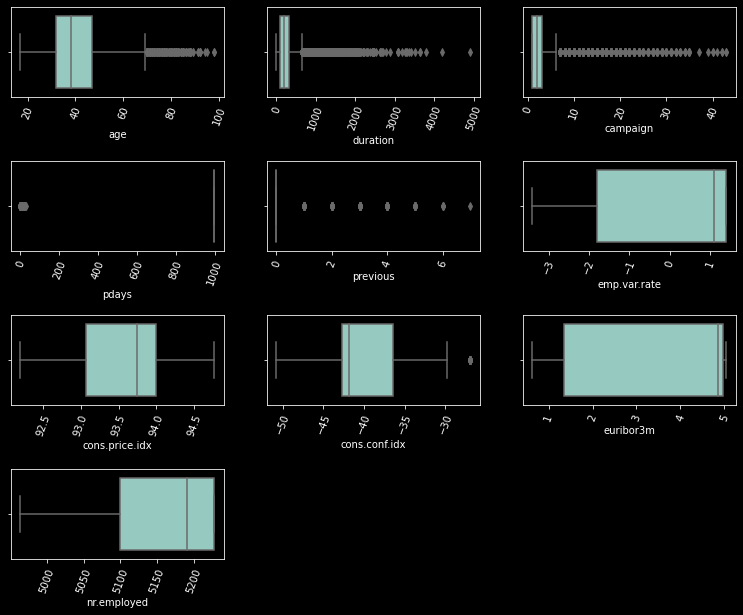

In [18]:
# Display numerical column on boxplot
plt.figure(figsize=(13,13))
plt.subplots_adjust(hspace=0.7)
for i, col in enumerate(df.select_dtypes('number')):
    ax = plt.subplot(5,3,i+1)
    plt.xticks(rotation = 70)
    sns.boxplot(data = df, x=col)
plt.show()

We will have a deep look on previous and pdays column since it seems like they have imbalance value. 

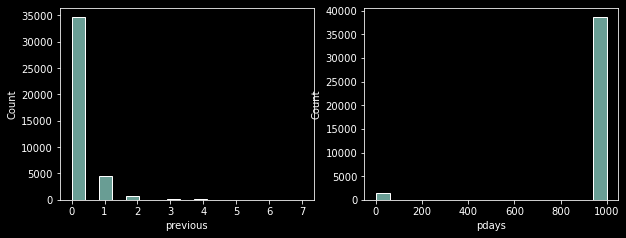

In [19]:
# Display histogram of previous column
plt.figure(figsize=(10,12))
for i, col in enumerate(df[['previous','pdays']]):
    ax = plt.subplot(3,2,i+1)
    sns.histplot(df, x=col)
plt.show()

According to dataset feature explanation we know that pdays column is number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted), and for previous column is about number of contacts performed before this campaign and for this client (numeric).  

On the ploting above, we find that most of value of pdays is 999 which means that most of them did not contacted after last campaign. As well as for previous column, 0 is dominate the value and that is to say for most client no contact performed before campaign. Accordingly, I am going to tranform both above columns into categorical:
- Previous: 0 values will be replaced as False (no contact performed before campaign) and others value will be True (there is contact performed before campaign regardless hom many contact had performed).
- Pdays: 999 values will be replaced as False (client was not previously contacted from a previous campaign) and others will be True (client was previously contacted from a previous campaign regardless number of days that passed by after the client was last contacted from a previous campaign).

In [20]:
# Replace the value on previous column.
df.loc[df['previous'] == 0, 'previous'] = 0 
df.loc[df['previous'] != 0, 'previous'] = 1 

# Replace the value on pdays column.
df.loc[df['pdays'] != 999, 'pdays'] = 1 
df.loc[df['pdays'] == 999, 'pdays'] = 0 
    

Now, let's transform all caterical column which has only two unique number (yes/no) to be numerical in order to have access on seeing the correlation with target column.

In [21]:
# Transform target column categoric to numeric.
for col in df.select_dtypes('object'):
    if len(df[col].unique()) == 2:
        df[col] = df[col].replace(['yes','no'],[1,0])
# Transform contact column categoric to numeric.    
df['contact'] = df['contact'].replace(['telephone','cellular'],[1,0])
df.sample()

,age,job,education,default,contact,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,has_loan,old_campaign
29748,25,self-employed,university.degree,no,0,apr,163,1,0,0,-1.8,93.075,-47.1,1.405,5099.1,1,1,0


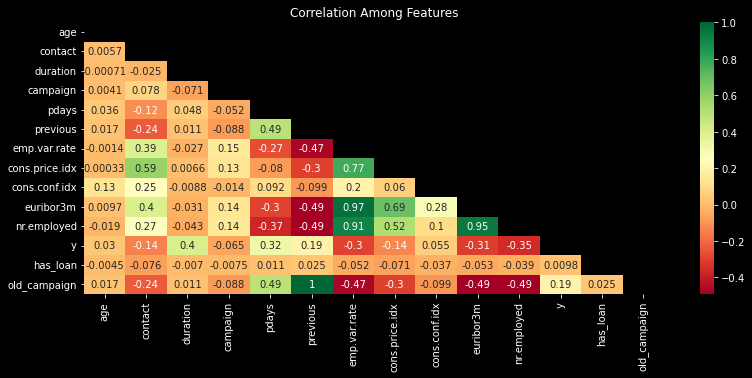

In [22]:
# Find and display corelation among columns
corr_matrix = np.triu(df.corr())
plt.figure(figsize=[13,5])
plt.title('Correlation Among Features')
sns.heatmap(df.corr(), annot = True, cmap='RdYlGn',mask=corr_matrix,)
plt.show()

The heatmap graph above shows correlation between all available numerical columns. Let's have a look more details correlation between features with the target only.

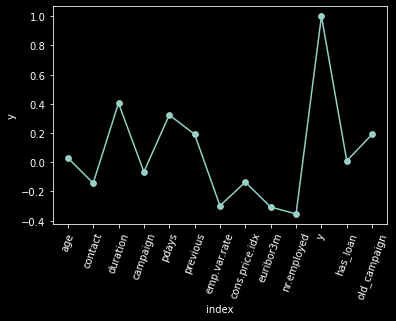

In [23]:
# Display correlation towards target column
corr = df.corr()['y'].reset_index()
corr.drop(labels=8,axis=0,inplace=True)
sns.lineplot(data= corr, x='index', y='y',)
sns.scatterplot(data= corr, x='index', y='y',)
plt.xticks(rotation = 70)
plt.show()

From correlation table above, we can see that the most correlated feature of the target is duration, pdays and nr.employed column. Let's have a look on the barplot. However, I won't use duration column as features model for the reason that I got from dataset explanation source.   

*"Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model."*

I will only take all numerical column that have correlation with target column as features on the future model.

In [24]:
# Store numerical column needed and remove duration column.
selected_col_num = corr['index'].values.tolist()
selected_col_num.remove('duration')


### VI. DATA PREPROCESSING

Let's have a look the ratio of labels on dataset to know whether this data is imbalance or not by comparing the total of each class on the labels.

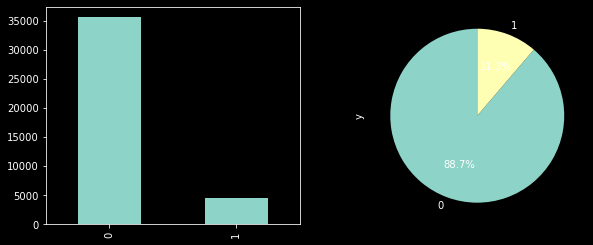

In [25]:
# Display countplot of DEATH_EVENT as target.
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
df['y'].value_counts().plot(kind='bar', ax=axs[0])
df['y'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[1])
plt.show()

Before splitting data, I will selected the numerical column once again using VIF (Variance Inflation Factors). And remove all column with value of vif above 5 to reduce recurrence of features because vif value shows feature high multicollinearity.

In [26]:
# Find vif value
selected_col_num.remove('y')
X1 = df[selected_col_num].copy()
vif_df = pd.DataFrame()
vif_df['feature'] = X1.columns
vif_df['vif'] = [vif(X1.values, i) for i in range(len(X1.columns))]
vif_df


/usr/local/homebrew/anaconda3/envs/Hacktiv8/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning:

divide by zero encountered in double_scalars



,feature,vif
0,age,1.589645e+01
1,contact,2.654305e+00
2,campaign,1.922139e+00
3,pdays,1.502437e+00
4,previous,inf
5,emp.var.rate,2.409235e+01
6,cons.price.idx,2.860369e+04
7,euribor3m,1.943402e+02
8,nr.employed,3.125204e+04
9,has_loan,2.520926e+00


In [27]:
# Remove features with high vif 
X2 = X1.copy()
X2_drop = ['previous','age','euribor3m','cons.price.idx']
X2.drop(X2_drop, inplace=True, axis=1)
vif_df = pd.DataFrame()
vif_df["feature"] = X2.columns
vif_df["vif"] = [vif(X2.values, i) for i in range(len(X2.columns))]
vif_df

,feature,vif
0,contact,1.868505
1,campaign,1.908269
2,pdays,1.373894
3,emp.var.rate,1.462966
4,nr.employed,4.422074
5,has_loan,2.520170
6,old_campaign,1.833127


Looks like the total of no is larger than the total of no and makes the dataset imbalanced. This will forsure influence the capability of model to learn on the train process. However, we will try some classifier model to find the best model to use later on. Now, I am goint to get data ready for training into future define model. Defining variables for each columnn type on features to perform train test split.

*Features Label separation*

In [28]:
# Define numerical and categorical columns
numerical_columns = vif_df['feature'].values.tolist()
categorical_columns = df.select_dtypes("object").columns.tolist()
columns = numerical_columns + categorical_columns
columns

['contact',
 'campaign',
 'pdays',
 'emp.var.rate',
 'nr.employed',
 'has_loan',
 'old_campaign',
 'job',
 'education',
 'default',
 'month']

In [29]:
df.sample()

,age,job,education,default,contact,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,has_loan,old_campaign
9318,40,blue-collar,basic.4y,unknown,1,jun,48,2,0,0,1.4,94.465,-41.8,4.967,5228.1,0,0,0


In [30]:
X = df[columns]
y = LabelEncoder().fit_transform(df.y)

*Perform train_test_split on the data*

In [31]:
X_train, X_test, y_train, y_test= train_test_split(X,y, stratify=y,random_state=42)
print("Train feature shape: ", X_train.shape)
print("Test feature shape: ", X_test.shape)

Train feature shape:  (30089, 11)
Test feature shape:  (10030, 11)


In [32]:
# Transfor categorical column using column transformer.
preprocess = make_column_transformer(
    (OneHotEncoder(),categorical_columns), 
    (RobustScaler(), numerical_columns),
    remainder= 'passthrough',
)
preprocess.fit_transform(X_train)

<30089x40 sparse matrix of type '<class 'numpy.float64'>'
	with 219809 stored elements in Compressed Sparse Row format>

### VII. DEFINE, TRAIN MODEL & EVALUATION

In [33]:
# Define model.
logreg = LogisticRegression(solver="lbfgs",max_iter=1000)
svc = SVC()
randfors = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean')
nabay = GaussianNB()
adaboost = AdaBoostClassifier()

In [34]:
# Create pipeline function for modeling.
def pipeline(name):
    return make_pipeline(preprocess, name)

In [35]:
def cross_validate(classifier):
    # Find cross_val_score
    cross_score = cross_val_score(pipeline(classifier), X_train,y_train, cv =5, scoring = 'accuracy').mean()
    pipeline(classifier).fit(X_train,y_train)
    
    # Predict data training and find it's accuracy score
    y_pred_train = pipeline(classifier).predict(X_train)
    acc_score_train = accuracy_score(y_train,y_pred_train)
    
    # Predict data testing and find it's score
    y_pred_test = pipeline(classifier).predict(X_test)
    acc_score_test = accuracy_score(y_test,y_pred_test)
    prec_score = precision_score(y_test,y_pred_test)
    rec_score = recall_score(y_test,y_pred_test)
    f1= f1_score(y_test,y_pred_test)
    
    # Get confusion matrix
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(y_test,y_pred_test), annot = True, cmap="YlGnBu",fmt='g',)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    
    print(f"Cross Validation  mean: {cross_score}")
    print(f"Precision : {prec_score}")
    print(f"Recall : {rec_score}")
    print(f"F1 : {f1}")
    
    print(f"Training Accuracy : {acc_score_train}")
    print(f"Validation Accuracy : {acc_score_test}")

Cross Validation  mean: 0.8989997157162938
Precision : 0.6781914893617021
Recall : 0.22566371681415928
F1 : 0.3386454183266932
Training Accuracy : 0.8992987470504171
Validation Accuracy : 0.9006979062811565


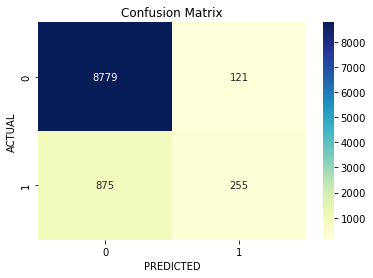

In [37]:
cross_validate(logreg)

Cross Validation  mean: 0.8986341291896291
Precision : 0.699724517906336
Recall : 0.2247787610619469
F1 : 0.34025452109845944
Training Accuracy : 0.9001960849479876
Validation Accuracy : 0.9017946161515453


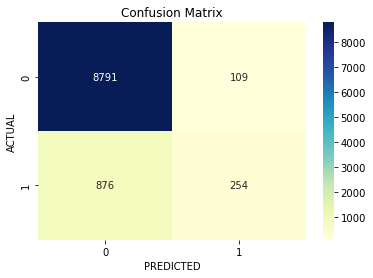

In [38]:
# cross_validate(svc)

Cross Validation  mean: 0.8879324134957601
Precision : 0.5038759689922481
Recall : 0.28761061946902655
F1 : 0.36619718309859156
Training Accuracy : 0.9422712619229618
Validation Accuracy : 0.8878364905284147


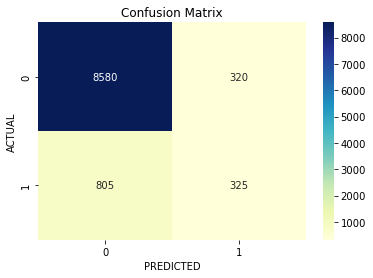

In [39]:
cross_validate(randfors)

Cross Validation  mean: 0.8945461990848683
Precision : 0.6143617021276596
Recall : 0.20442477876106194
F1 : 0.3067729083665338
Training Accuracy : 0.9036857323274287
Validation Accuracy : 0.8959122632103689


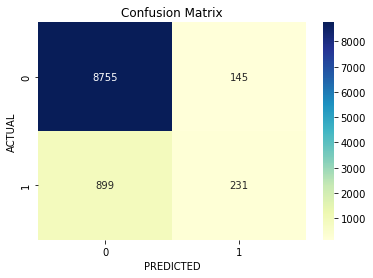

In [40]:
cross_validate(knn)

Cross Validation  mean: 0.4527238847415429
Precision : 0.15193457061969173
Recall : 0.8548672566371681
F1 : 0.25801282051282054
Training Accuracy : 0.4491010003655821
Validation Accuracy : 0.446061814556331


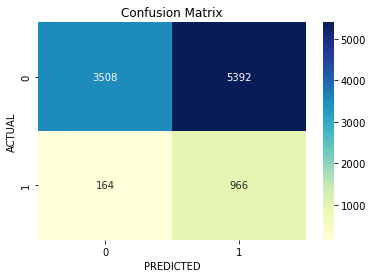

In [41]:
cross_validate(nabay)

Cross Validation  mean: 0.8986673738686439
Precision : 0.6513317191283293
Recall : 0.23805309734513275
F1 : 0.3486714193130266
Training Accuracy : 0.8989996344178935
Validation Accuracy : 0.8998005982053838


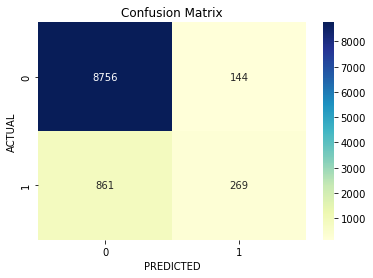

In [42]:
cross_validate(adaboost)

#### GRID SEARCH

After train data using some of classifier model above, we found that each model is not significantly different in accordance with the cross validation, f1, and its accuracy score. However, I will choose SVC model this time considering it's data training and data testing score almost the sama which indicate that there is no overfitting or underfitting on the model itself. Besides, the time consuming when trained this model is not significantly different compare with other models I use to train above.

In this section, I will try to improving SVC model performance by doing hyperparameter tuning using gridsearhCV. The best parameters will be used as final paramater on this model.

In [36]:
# Parameter tuning using gridsearchCV
parameter={
    'model__kernel':['sigmoid','rbf','linear'],
    'model__C': [10,100],
    'model__gamma': [0.1, 1], 
}
pipe =Pipeline(
    [
        ('preprocess', preprocess,),
        ('model', svc,),
    ],
    
)

grid = GridSearchCV(pipe, param_grid= parameter, cv=5)

In [38]:
grid.fit(X_train, y_train)


*
*
*
*
*
*
*
*
*
*

In [ ]:
print(f"Best estimator: {grid.best_estimator_}")
print(f"Best parameter: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

In [ ]:
y_predict = grid.predict(X_test)

### VIII. MODEL INFERENCE

The model has been trained, now it's time to check the model by creating new data and predict the result. New data will be created by taking 5 random data from dataset and predict the result, then I will compare the actual value with the predicted value from the SVC model.

In [ ]:
df.head()

In [ ]:
df.sample(n=5, random_state=3)

**Create Model Persistence using Joblib**

In [ ]:
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

### IX. CONCLUSION

**Overall Analysis**

- This dataset is imbalanced dataset with total label value No is larger than Yes.
- There is no missing point found in this dataset, however there are many unknown value which is treated similar with null value that might affect the model training.
- Most of the client that successfully subscribed the deposit term of the bank was mostly come from the client that attent the previous campaign aswell. It is indicate that the client is please and satisfied with the campaign from the bank.
- Most of the participant of this campaign was from client with profession as Admin and education background was University Degree. Contrarily there was no participant from people with illiterate background and less student join this campaign.
- Pdays and nr.employed features was the strongest factors that influence the client behaviour to subscribe the deposit term on the campaign which means the client who were contacted before campaign tends to subscribe the term deposit.
  

**Model Analysis**

- The scoring value of each model that have been trained almost similar except for Naive Bayes Classifer with the lowest scoring value compare to others model.
- Accucary score for data training and data testing almost the same which means that there is no underfitting or overfitting on the model and the model learned well on training.
- The best model among others model to use for this dataset is SVC with the score, as follows:
    1. Training accuracy score = 0.90.
    2. Testing accuracy score = 0.90.
    3. Confusion matrix:
       - TP = 254 positif cases correctly predicted
       - TN = 8791 negative cases correctly predicted
       - FP = 876 positive cases wrongly predicted
       - FN = 109 negative cases wrongly predicted
- Despite SVC model is the best model in scoring, it's one of the time consuming model on training and it cost more than other model. Yet, I chosed SCV model for this dataset as the load of dataset is not massive. However, for fat dataset, choosing other model like logistic regression will be wiser.